In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker, cm, colors
import xarray as xa

In [2]:
large = 24; med = 20; small = 16
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 4),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'axes.titlepad': 6}
plt.rcParams.update(params)

In [3]:
H0 = 2000. #m

a=10000.
ll=8000.
dx=1000.
Nx = 100 #integer
x0 = Nx*dx/2.

#vertical profile
zt1=10000.
zt2=14000.

N1=0.01
N2=0.02
U1=0.0
U2=20

T00 = 300.
ps0 = 1.e5 #pa

grav=9.81 #m/s
cp=1004.
R=287.
kappa=R/cp #dry
rkappa=1./kappa

Many idealized mountain flow test cases are specified for height coordinates and given layers with constant Brunt-Vaisala frequency. However for a hydrostatic initial state, height depends on temperature and the levels depend on surface pressure. So we need to invert the usual process. This is made much easier using the Pi-Theta system:

$\pi = \left(\frac{p}{p_{00}} \right )^\kappa$, where $\kappa = \frac{R_d}{c_p}$

$\theta = T/\pi$

Here $p_{00}$ is a reference pressure; conventionally this is set to $10^5$ Pa but can be any value. For convenience in FV3 we use $p_{00} = 1$ Pa, which saves us a few flops (just use $p^\kappa$).

Hydrostatic balance is written as:

$c_p \theta \frac{d\pi}{dz} = -g$

which has a number of advantages for calculation, especially if the background state is given in terms of the Buoyancy (B-V) frequency $N^2 = \frac{g}{\theta} \frac{d\theta}{dz}$. From this, if we are given the surface height $z_s$ and constant $N$ we can simply integrate to get the surface value $\theta_s$:

$\theta_s = \theta_0 \exp\left(\frac{N^2 z_s}{g} \right)$ where $\theta_0 = T_0/\pi_0$, the potential temperature at $z=0$.

We can then solve the hydrostatic balance equation using separation of variables to get surface $\pi_s$:

$\pi_s = \frac{1}{c_p} \left ( \frac{g}{N}\right )^2  \left [ \frac{1}{\theta_s} - \frac{1}{\theta_0} \right ] + \pi_0$

from which $p_s$ can be easily calculated. Once we have $p_s$ we can compute the full hybrid coordinate.

In [4]:
#1. Set up horizontal Grid and Schar topography
xx = np.arange(Nx)*dx
xxp=xx-x0
zs1 = np.cos(np.pi*xxp/ll)
zs = H0*np.exp(-xxp*xxp/(a*a))*zs1*zs1

#Assume topo stays below zt1
th00 = T00/pow(ps0,kappa) #K

ths = th00*np.exp(zs*N1*N1/grav)
pis=pow(ps0,kappa) + grav*grav/(cp*N1*N1)*(1./ths - 1./th00)
ps=pow(pis,rkappa)

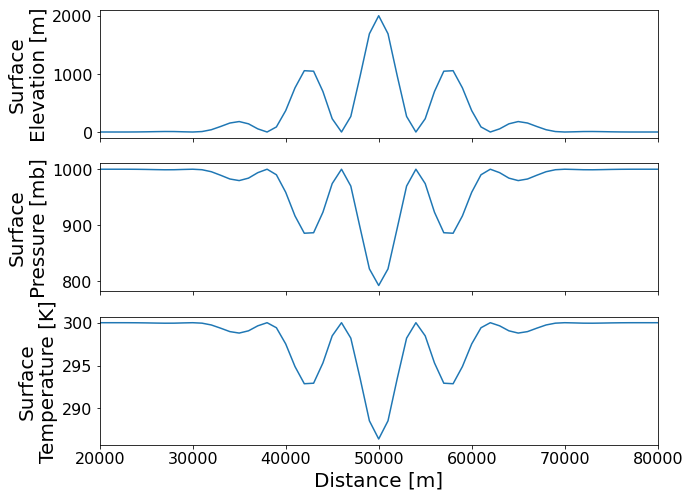

In [5]:
fig,ax=plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(10,8))

ax[0].plot(xx,zs)
ax[0].set_ylabel("Surface\nElevation [m]")

ax[1].plot(xx,ps/100.)
ax[1].set_ylabel("Surface\nPressure [mb]")

ax[2].plot(xx,ths*pis)
ax[2].set_ylabel("Surface\nTemperature [K]")
ax[2].set_xlim((20.e3,80.e3))

ax[2].set_xlabel("Distance [m]");

In [6]:
#Set up pressure surfaces assuming constant dz
#(Unfortunately this doesn't really work---resulting coordinate has discontinuities over topography)
# I am presenting this for illustrative purposes only; needs work.
Nz=40
dz=500.

ak=np.zeros(Nz+1)
bk=np.zeros(Nz+1)
ak[-1] = 0.0 ; bk[-1] = 1.0
pp=np.zeros(Nz+1)
pp[-1] = ps0

#Interface between hybrid and pure pressure
zt=10000. 

thp=th00
pk0=pow(ps0,kappa)
pkp=pk0

tht=th00*np.exp(zt*N2*N2/grav)
pkt=pk0 + grav*grav/(cp*N2*N2)*(1./tht - 1./th00)
p_t = pow(pkt,1./kappa)

ze=0.0
for k in range(Nz,0-1,-1):
    ze = ze+dz
    if ze >= zt2:
        thn = thp* np.exp(dz*N2*N2/grav)
        pkn = pkp + grav*grav/(cp*N2*N2)*(1./thn - 1./thp)
    else:
        thn = thp* np.exp(dz*N1*N1/grav)
        pkn = pkp + grav*grav/(cp*N1*N1)*(1./thn - 1./thp)
    pp[k] = pow(pkn,1./kappa)
    
    if pp[k] <= p_t:
        ak[k] = pp[k]
        bk[k] = 0.0
    else:
        ak[k] = p_t*(pp[k]-ps0)/(p_t-ps0)
        bk[k] = (pp[k]-p_t)/(ps0-p_t)
    pkp = pkn
    thp = thn

In [7]:
#Use a standard set of ak/bk

ds=xa.open_dataset("/archive/Lucas.Harris/SHiELD/202103/d96_1k.solo.mtn_rest.diff2-origak//history/0000000000/atmos_static.nc",decode_times=False)

ak = ds.pk.values
bk = ds.bk.values

pp = ak + ps0*bk
Nz=len(ak)-1

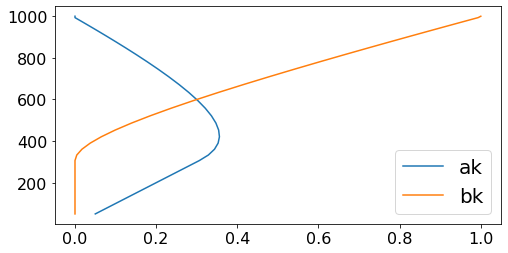

In [8]:
plt.plot(ak/ps0,pp/100.,label='ak')
plt.plot(bk,pp/100.,label='bk')
plt.legend()

In [9]:
npz = len(ak)
pe = np.tile(ps,[npz,1])
pe = (pe.T * bk + ak).T

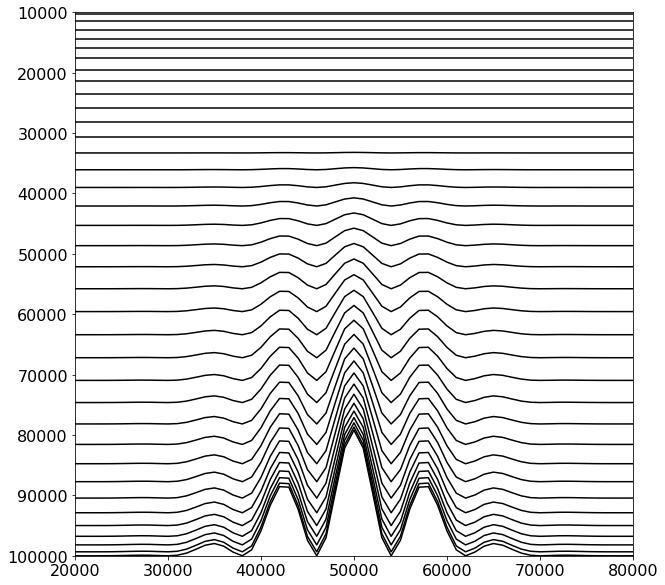

In [10]:
plt.figure(figsize=(10,10))
plt.plot(xx,pe.T,color='k')
plt.gca().set_xlim((20.e3,80.e3))
plt.gca().set_ylim((1.e4,1.e5))
plt.gca().invert_yaxis()
#plt.gca().set_yscale('log')

To compute $\theta$ and thereby regular temperature from $N$ and the assigned pressure levels, we can apply chain rule and the hydrostatic relation to the definition of the buoyancy frequency

$N^2 = -\left(\frac{g}{\theta}\right)^2 \frac{1}{c_p} \frac{d\theta}{d\pi}$

and then solve for $\theta$ again using separation of variables, integrating upward from the surface and the known $\theta_s$:

$\frac{1}{\theta_k} - \frac{1}{\theta_{k+1}} = -c_p \left ( \frac{N}{g} \right )^2 \left ( \overline{\pi}_{k+1} - \overline{\pi}_k \right )$

with the lowest layer computed using the lower boundary condition $\frac{1}{\theta_N} - \frac{1}{\theta_{s}} = -c_p \left ( \frac{N}{g} \right )^2 \left ( \pi_{s} - \overline{\pi}_N \right )$.

Since in FV3 $\theta$ is defined as a layer-mean we use the layer-mean Exner function $\overline{\pi} = \overline{p}^\kappa$, noting that layer-mean pressure is computed as

$\overline{p} = \frac{\delta p}{\delta \log p}$,

*not* $0.5\left ( p_{k+1} + p_k \right )$. Doing the latter marks one as a total noob.

Note that these relations can be turned around to get reference (ps = 1000 mb) interface pressures to define layers with constant $\Delta z$, integrating up from a given $\theta_B$ and $\pi_B$:

$\pi(z) = \pi_B \frac{g^2}{c_p N^2} \left [ \frac{1}{\theta(z)} - \frac{1}{\theta_B} \right ]$

in which $\theta(z) = \theta_B \exp \left ( \frac{N^2}{g} \left(z-z_B\right) \right )$ in a constant $N$ layer.

In [11]:
#Compute cell-mean theta and delz
delp=np.diff(pe,axis=0)
dlnp=np.diff(np.log(pe),axis=0)
pm=delp/dlnp
pk=pow(pm,kappa)

ze=pe*0.0

th=delp*0.0
delz=th*0.0
T=th*0.0

#Start by computing N=N1 everywhere
rth=1./th00 - (N1*N1/(grav*grav))*cp*(pow(ps0,kappa)-pk)
th=1./rth
T=th*pk

delz=-(R/grav)*T*dlnp
z = np.zeros((npz,Nx)) + zs
z[:-1,:] = z[:-1,:] - np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)
zm = 0.5*(z[:-1,:] + z[1:,:])

#Now compute N=N2 where zm is above zt2

kt=np.argmax(zm>zt2,axis=0)
for i in range(Nx):
    k=kt[i]
    rth=1./th[k,i] - (N2*N2/(grav*grav))*cp*(pk[k,i]-pk[:k,i])
    th[:k,i]=1./rth

T=th*pk

#Then recompute z and zm with the new z
delz=-(R/grav)*T*dlnp
z = np.zeros((npz,Nx)) + zs
z[:-1,:] = z[:-1,:] - np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)
zm = 0.5*(z[:-1,:] + z[1:,:])


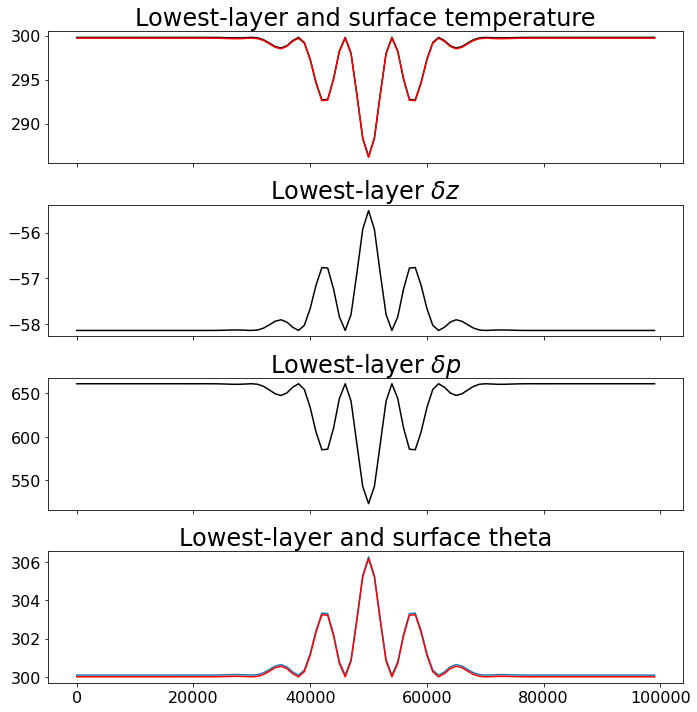

In [12]:
fig,ax=plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(10,10))
k=npz-1-1

ax[0].plot(xx,T[k,:],color='k')
ax[0].plot(xx,ths*pk[k,:],color='r')
ax[0].set_title("Lowest-layer and surface temperature")

ax[1].plot(xx,delz[k,:],color='k')
ax[1].set_title("Lowest-layer $\delta z$")


ax[2].plot(xx,ps-pe[k,:],color='k')
ax[2].set_title("Lowest-layer $\delta p$")

ax[3].plot(xx,th[-1,:]*pow(ps0,kappa),label="Lowest-layer theta")
ax[3].plot(xx,ths*pow(ps0,kappa),color='r',label="Surface theta")
ax[3].set_title("Lowest-layer and surface theta")

plt.tight_layout()

<ipython-input-13-11c918301d9a>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cb=ax[0].pcolormesh(xx,pe/100.,th*pow(ps0,kappa))
<ipython-input-13-11c918301d9a>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cb=ax[1].pcolormesh(xx,z,th*pow(ps0,kappa))


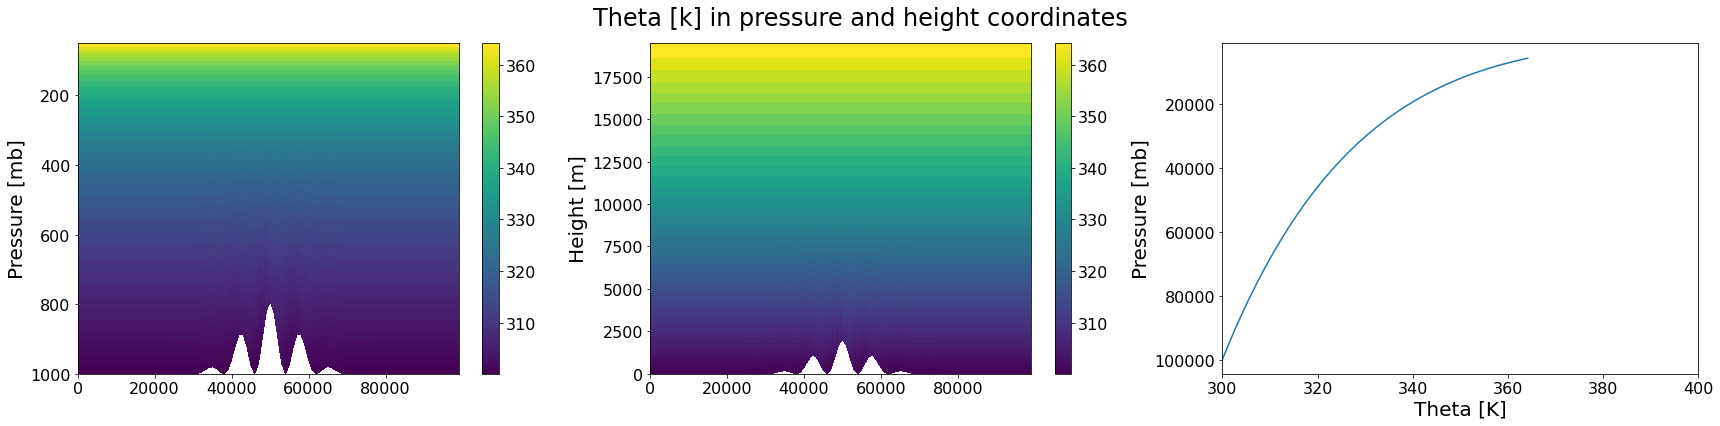

In [13]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(24,6))

cb=ax[0].pcolormesh(xx,pe/100.,th*pow(ps0,kappa))
plt.colorbar(cb,ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_ylabel("Pressure [mb]")

cb=ax[1].pcolormesh(xx,z,th*pow(ps0,kappa))
plt.colorbar(cb,ax=ax[1])
ax[1].set_ylabel("Height [m]")

ax[2].plot(th[:,0]*pow(ps0,kappa),pm[:,0])
ax[2].invert_yaxis()
ax[2].set_ylabel("Pressure [mb]")
ax[2].set_xlabel("Theta [K]")
ax[2].set_xlim((300,400))

plt.suptitle("Theta [k] in pressure and height coordinates")
plt.tight_layout()

<ipython-input-14-6852c16e00c7>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,z,-delz)
<ipython-input-14-6852c16e00c7>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,z,delp)


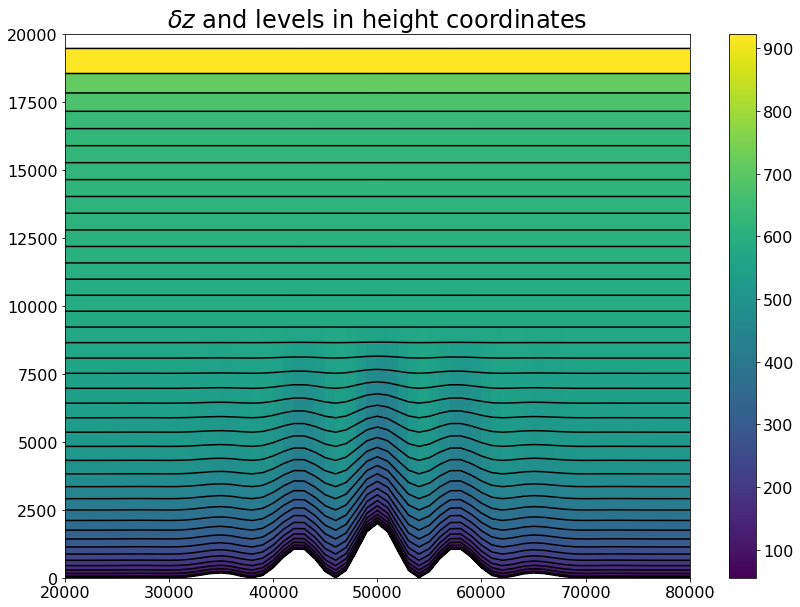

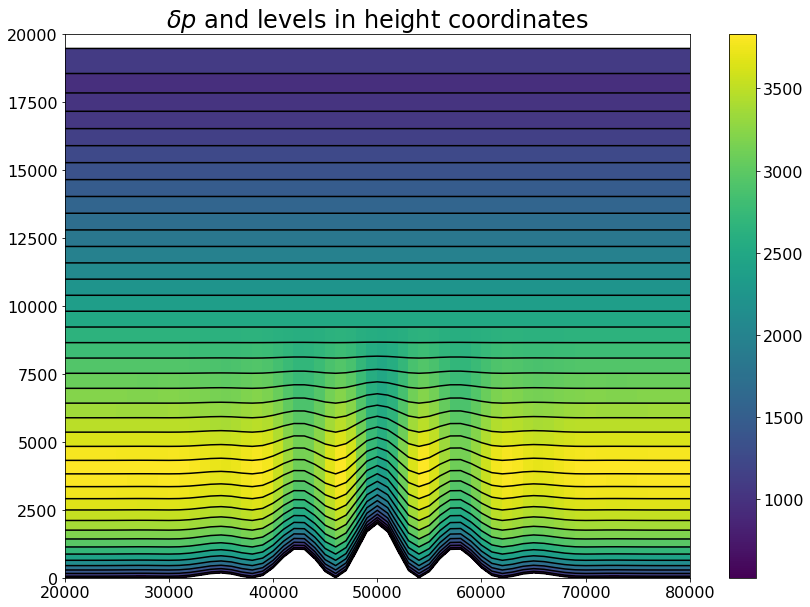

In [14]:
plt.figure(figsize=(14,10))
plt.pcolormesh(xx,z,-delz)
plt.plot(xx,z.T,color='k')
plt.gca().set_xlim((20.e3,80.e3))
plt.gca().set_ylim((0,20.e3))
plt.gca().set_title("$\delta z$ and levels in height coordinates")
plt.colorbar()

plt.figure(figsize=(14,10))
plt.pcolormesh(xx,z,delp)
plt.plot(xx,z.T,color='k')
plt.gca().set_xlim((20.e3,80.e3))
plt.gca().set_ylim((0,20.e3))
plt.gca().set_title("$\delta p$ and levels in height coordinates")
plt.colorbar()